Complete the exercises below For **Assignment #11**.

For this assignment we'll use the [California Housing Data](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html).

This data is available in the [Scikit-Learn](https://scikit-learn.org/stable/index.html) Python module.

To retrieve the data,
1. open a new Python notebook with the `data730` kernel, and,
2. run the following code.

```python
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)

(
    california_housing.data
    .assign(MedianHouseValue=california_housing.target)
    .to_csv('california-housing.csv', index=False)
)
```

This will produce a new file called `california-housing.csv` that we'll import in this notebook.

Back in the Python notebook, you can use the following snippet to get a description of the dataset.

```python
print(california_housing.DESCR)
```


Load the `tidymodels` package.

In [1]:
library('tidymodels')
library('vip')



Warning message:
“Your system is mis-configured: ‘/var/db/timezone/localtime’ is not a symlink”
Warning message:
“‘/var/db/timezone/localtime’ is not identical to any known timezone file”
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.7     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.2.1
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.1.0
✔ purrr        1.0.2     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages


Attaching package: ‘vip’


The following

Run the following cell to read in our data.

In [2]:
housing = readr::read_csv('california-housing.csv', col_types = readr::cols())

housing |> head()

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.3252,41,6.984127,1.0238095,322,2.555556,37.88,-122.23,4.526
8.3014,21,6.238137,0.9718805,2401,2.109842,37.86,-122.22,3.585
7.2574,52,8.288136,1.0734463,496,2.802260,37.85,-122.24,3.521
5.6431,52,5.817352,1.0730594,558,2.547945,37.85,-122.25,3.413
3.8462,52,6.281853,1.0810811,565,2.181467,37.85,-122.25,3.422
4.0368,52,4.761658,1.1036269,413,2.139896,37.85,-122.25,2.697


Let's build a random forest model to predict `MedianHouseValue`.

1. Create your model, set the engine to `ranger` with `importance = 'impurity'` and the mode as `regression`.
2. Fit the model using `MedianHouseValue` as the response variable and all other columns as predictors.

In [3]:
mod = rand_forest() |>
    set_engine('ranger', importance = 'impurity') |>
    set_mode('regression')

rec = recipe(MedianHouseValue ~., data = housing)

#rec |> juice() |> head()




In [4]:
wf = workflow() |>
    add_recipe(rec) |>
    add_model(mod)

wf_fit = wf |> fit(data = housing)
wf_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: rand_forest()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────
Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, importance = ~"impurity",      num.threads = 1, verbose = FALSE, seed = sample.int(10^5,          1)) 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      20640 
Number of independent variables:  8 
Mtry:                             2 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        variance 
OOB prediction error (MSE):       0.2315628 
R squared (OOB):                  0.8261037 

❓ What is the OOB error for this model?

**Answer:**

The OOB error for this model is .8246616



Plot the feature importances using the `vip` package. Remember that you can use the `extract_fit_engine` function to get the `ranger` model object to send to the `vip` function.

.pred,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.360791,8.3252,41,6.984127,1.0238095,322,2.555556,37.88,-122.23,4.526
3.846087,8.3014,21,6.238137,0.9718805,2401,2.109842,37.86,-122.22,3.585
3.892321,7.2574,52,8.288136,1.0734463,496,2.802260,37.85,-122.24,3.521
3.493149,5.6431,52,5.817352,1.0730594,558,2.547945,37.85,-122.25,3.413
3.015381,3.8462,52,6.281853,1.0810811,565,2.181467,37.85,-122.25,3.422
2.622359,4.0368,52,4.761658,1.1036269,413,2.139896,37.85,-122.25,2.697


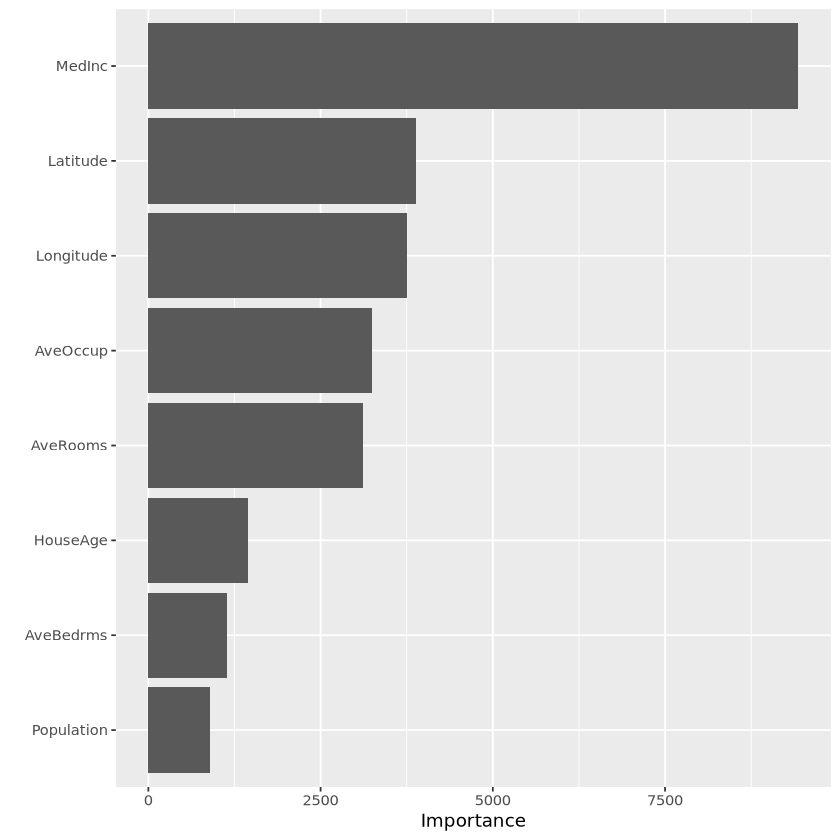

In [5]:
# Had to re-define rec here because initially I could not use the workflow if I defined the recipe including prep() at the end so left it that way to train the model
# and now redefining it with prep() so that I can utilize juice() in the augment function
rec = recipe(MedianHouseValue ~., data = housing) |>
    prep()


outcomes = augment(wf_fit |> extract_fit_parsnip(),
                   new_data = rec |> juice())
outcomes |> head()

wf_fit |>
    extract_fit_engine() |>
    vip()



It looks like `Latitude` and `Longitude` are important for predicting home value. Let's explore those variables.

Install the `mapdata` package into your `data730` environment.

1. Open a Terminal, and,
2. Run the following command:

```bash
conda install -c conda-forge -n data730 r-mapdata
```

Load the `mapdata` package.

In [6]:
library('mapdata')



Loading required package: maps


Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map




The following code will generate a map of California. Adapt this code to plot `Latitude` and `Longitude` from the `housing` dataset, color points by the `MedianHouseValue`. [Here is an example for reference](https://raw.githubusercontent.com/UNC-DATA-730/a10/main/example.png).


```r
california = map_data("state") |> filter(region == 'california')

ggplot(data = california) + 
    geom_polygon(aes(x = long, y = lat), fill = "grey90", color = "grey40") +
    coord_quickmap() +
    theme_void()
```

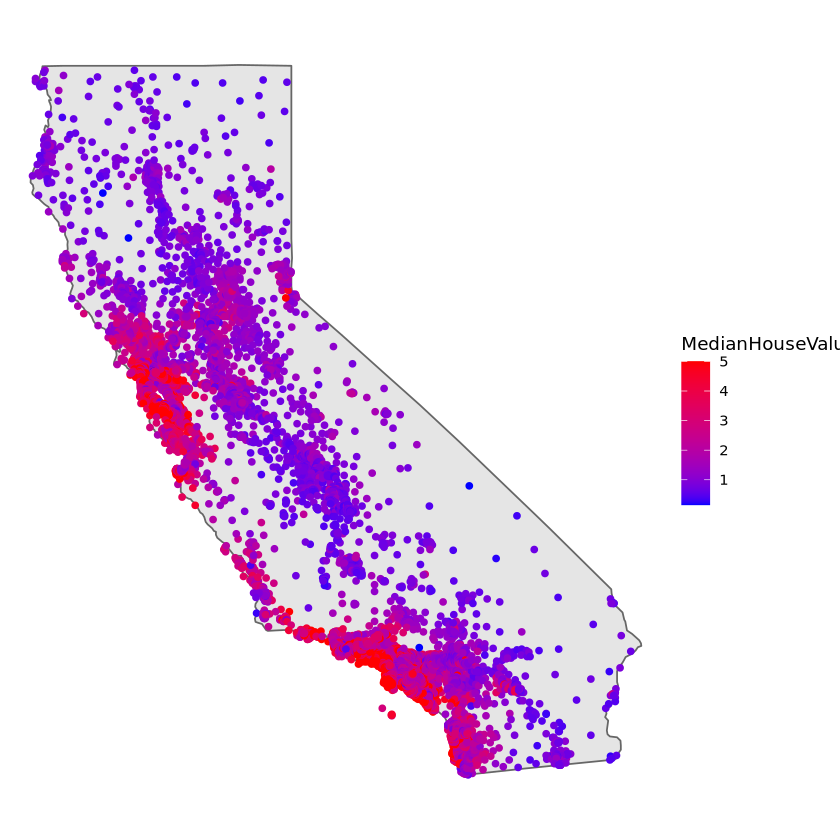

In [7]:
california = map_data("state") |> filter(region == 'california')

ggplot(data = california) + 
    geom_polygon(aes(x = long, y = lat), fill = "grey90", color = "grey40") +
    coord_quickmap() +
    theme_void() +
    geom_point(data = housing, aes(x = Longitude, y = Latitude, color = MedianHouseValue)) +
    scale_color_gradient(low = "blue", high = "red")


